In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle as pickle
import gzip 
from pylab import *
from __future__ import division

In [89]:
PNdata = pickle.load(gzip.open('/Users/Sri/Desktop/Int_and_Fire/Data/PNdata.pklz'))
pulse_labelsPN = pickle.load(gzip.open('/Users/Sri/Desktop/Int_and_Fire/Data/pulselabelsPN.pklz','rb'))
number_of_datasetsPN = 5

LNdata = pickle.load(gzip.open('/Users/Sri/Desktop/Int_and_Fire/Data/LNdata.pklz','rb'))
pulse_labelsLN = pickle.load(gzip.open('/Users/Sri/Desktop/Int_and_Fire/Data/pulselabelsLN.pklz','rb'))
number_of_datasetsLN = 8

### Leaky Integrate and Fire Model (LIF)

The leaky integrate and fire model consists of a 1st order inhomogenous differential equation and a fire & reset rule. $$C_m\frac{dV_m}{dt} = g_l(V_{eq} - V_m) $$

1. $C_m$ : membrane capacitance
2. $V_m$ : membrane potential
3. $g_l$ : membrane conductance ($1/R_m$ - membrane resistance)
4. $V_{eq}$ : equilibrium potential (i.e. potential when membrane is at rest)


When the membrane voltage exceeds a certain threshold, $V_{th}$, we observe a spike followed by a reset of membrane potential to the reset potential $V_{res}$, followed by a refractory period in which a spike cannot be observed.

This allows us to rewrite our differential equation as.

$$  
    \frac{dV_m}{dt}=\left\{
                \begin{array}{ll}
                  \frac{1}{\tau_m} (-V_m + IR_m), t>t_{rest}\\
                  V_{eq}, otherwise\\
                \end{array}
              \right.
$$

with a solution given by.

$$V(t) = V_{eq} (1-\exp({\frac{-t}{\tau_m}})) + R_m I ( 1-\exp({\frac{-t}{\tau_m}}))$$

for long times this reduces to

$$V_h = V_{eq} + R_mI_h $$where $$V(t \rightarrow \infty) = V_h $$




1. $\tau_m$ : membrane time constant
2. $V_h$ : holding potential
3. $I_h$ : holding current

 
To fit a LIF model to Jan's recorded data for LNs and PNs, we need to extract the model parameters. Specifically,

1. $V_{th}$
2. $V_{res}$
3. $\tau_m$
4. $R_m$
5. $C_m$


### Parameter Extraction

In [90]:
#look at data shape
PN_data = []
for dataset,data in enumerate(PNdata):
    PN_data.append(data)
    
LN_data = []
for dataset,data in enumerate(LNdata):
    LN_data.append(data)
print '(#of sweeps,','#number of datapoints)'
print 'data for PNs'
for dataset in range(len(PN_data)):
    print PN_data[dataset].shape
print 'data for LNs'   
for dataset in range(len(LN_data)):
    print LN_data[dataset].shape

(#of sweeps, #number of datapoints)
data for PNs
(8, 220000)
(5, 220000)
(7, 220000)
(8, 220000)
(5, 220000)
data for LNs
(11, 160000)
(15, 160000)
(18, 160000)
(20, 160000)
(8, 160000)
(12, 160000)
(9, 160000)
(10, 160000)


In [91]:
def local_maxima(d):
    '''
    returns bool array with the same shape as `d` with elements at the position of local maxima in `d` are set to `True`
    this function simply checks if the neighbouring elements are smaller or equal and is __sensitive to noise__
    '''
    return r_[True, d[1:] >= d[:-1]] & r_[d[:-1] > d[1:], True]

 #### Reset Potential $V_{res}$ & Equilibrium Potential $V_{eq}$

__Reset potential__ $V_{res}$ can be calculated from the minimum of the membrane potential after a spike has occurred. We can look at these minimas for a a particular sweep and use them to calculate an average and a standard deviation. Here it is calculated using the ```reset ``` function.



In [92]:
def reset(sweep):
    """
    Function to take an input of a sweep and return an integer value of the mean reset potential for that sweep 
    along with its standard deviation in mV.
    
    Inputs:
    -------
    sweep : array like
    
    Outputs:
    --------
    Mean Reset Potential : float
    Standard Dev of Reset Potential : float
    
    """
    dt = 1/20000 #1/sampling rate (Hz)
    th = 0 # use threshold of 0 mV for AP detection. the AP waveform is not very noise so the below works
    
    V = sweep
    V_maxima = (local_maxima(V) & (V>th))
    indices = V_maxima.nonzero()[0]
    
    chunk_list = [] #chunk of spectrum for each action potential
    time_list = [] #the times for each action potential

    ten_ms = dt*200 #10 ms in terms of dt

    ten_ms_idx = int(ten_ms/dt)#10 ms in terms of indices

    for index in indices:
        start = index-ten_ms_idx
        end = index+ten_ms_idx
        chunk = V[start:end]
        time = np.arange(start,end)
        chunk_list.append(chunk)
        time_list.append(time)    
        
    average_waveform = np.mean(chunk_list,axis = 0) #calculating the average waveform by averaging over the chunks

    time = len(average_waveform)*dt
    time = np.arange(0,time,dt)

    reordered_chunks = [[] for x in xrange(len(average_waveform))] 

    for waveform in range(len(chunk_list)):
        for chunk in range(len(average_waveform)):
            reordered_chunks[chunk].append(chunk_list[waveform][chunk])

    mean_waveform = []
    std_dev = []

    for chunk in range(len(reordered_chunks)):
        mean_waveform.append(np.mean(reordered_chunks[chunk]))
        std_dev.append(np.std(reordered_chunks[chunk]))

    return float(format(min(mean_waveform),'.3f'))*1e3,float(format(max(std_dev),'.3f'))*1e3
    


__Equilibrium potential__ $V_{eq}$ can be calculated from the mean of the membrane potential pre-stimulation. Here it is calculated using the ```equilibium ``` function.

In [93]:
def equilibrium(sweep,stim_start):
    """
    function that takes a particular sweep as an input, and returns the equilibrium in mV
    
    Inputs:
    -------
    sweep : array of a particular sweep (mV)
    stim_start : float time at which stimulation started (s)
    
    Outputs:
    --------
    mean reset potential : float (mV)
    standard deviation of reset potential : float (mV)
    mean membrane potential : float (mV)
    standard deviation of membrane potential : float (mV)
    
    """
    
    dt = 1/20000 # 1/sampling frequency (Hz)
    
    V = sweep
    
    idx_stim_start = int(stim_start/dt)

    V_sub_before = V[:idx_stim_start]
    
    return V_sub_before.mean()/1e-3,V_sub_before.std()/1e-3
        

can extend the ```equilibrium ``` function above with the ```mean_equilibrium``` function, which can find the average of the equilibrium potential over all the sweeps of a particular recording.


In [94]:
dt = 1/20000 #1/sampling frequency (Hz)

stim_start_PN = 3 #seconds
stim_end_PN   = 8 #seconds

idx_stim_start_PN = int(stim_start_PN/dt)
idx_stim_end_PN =   int(stim_end_PN/dt)

stim_start_LN = 1 #seconds
stim_end_LN   = 5 #seconds

idx_stim_start_LN = int(stim_start_LN/dt)
idx_stim_end_LN =   int(stim_end_LN/dt)

In [95]:
def mean_equilibrium(recording,stim_start):
    """
    Function that takes a set of sweeps, or recording, as an input and returns the mean equilibrium potential 
    over all of the recordings.
    
    Inputs:
    -------
    recording : list of lists
    stim_start : time in seconds of when the stimulation starts
    
    Outputs:
    --------
    Mean Equilibrium potential : float
    Standard Devitation of Equilibrium Potential : float
    
    """
    Voltages = []
    
    data = recording
        
    Equilibrium_Potential = []
    Equilibrium_Potential_std = []
    
    for recording,voltage in enumerate(data):
        Voltages.append(voltage)
        

    for dataset in range(len(Voltages)):
        V = np.empty_like(Voltages[dataset])
        V[:] = Voltages[dataset]
        Equilibrium_Potential.append(equilibrium(Voltages[dataset],stim_start)[0])
        Equilibrium_Potential_std.append(equilibrium(Voltages[dataset],stim_start)[1])

                
    return np.mean(Equilibrium_Potential), np.mean(Equilibrium_Potential_std)


#### Threshold Potential $V_{th}$

We assume that the threshold is given by the maximum of the derivative of the membrane potential $\frac{dV_m}{dt}$. We can use the ```threshold``` function to find the threshold for a particular sweep

In [96]:
def threshold(sweep):
    """
    Function to plot the distributions of the threshold voltage as well as return the mean 
    value of the threshold for a particular sweep.
    
    Input:
    ------
    sweep : an array containing the data for a particular sweep
    
    Output:
    -------
    plot : figure displaying frequency distribution of the threshold voltages
    Mean Value of threshold : float (mV)
    """

    chunk_list_dash = []
    chunk_list_dash_idx = []
    V_unmasked = sweep

    V = V_unmasked

    th = 0 # use threshold of 0 mV for AP detection. the AP waveform is not very noise so the below works
    V_maxima = (local_maxima(V) & (V>th))
    indices = V_maxima.nonzero()[0]
    twenty_ms = dt*400 #20 ms in terms of dt
    twenty_ms_idx = int(twenty_ms/dt)#20 ms in terms of indices


    chunk_list_dash = []
    chunk_list_dash_idx = []

    for index in range(len(V)):
        if index in indices:
            start = index-twenty_ms_idx
            end = index+twenty_ms_idx
            chunk = V_unmasked[start:end]
            chunk = list(chunk)
            chunk_idx = np.arange(start,end)
            chunk_dash = np.diff(chunk)
            chunk_list_dash.append(chunk_dash)
            chunk_list_dash_idx.append(chunk_idx)


    V_dash_idx = [] #list of derivatives with associated indices for each spike

    for chunk_dash in range(len(chunk_list_dash)):
        tuples = zip(chunk_list_dash[chunk_dash],chunk_list_dash_idx[chunk_dash])
        V_dash_idx.append(tuples)


    V_idx = [[] for x in xrange(len(V_dash_idx))]

    for V_dash_chunk in range(len(V_dash_idx)):
        for step in range(len(V_dash_idx[V_dash_chunk])):
            if V_dash_idx[V_dash_chunk][step][0] >= max(chunk_list_dash[V_dash_chunk]):
                V_idx[V_dash_chunk].append(V_dash_idx[V_dash_chunk][step][1])



    V_idx_first = [] # indices where threshold is crossed according to our condition.

    for index_list in range(len(V_idx)):
        V_idx_first.append(V_idx[index_list][0])


    # now just need to find V values that correspond to the indices in V_idx_first
    V_thresh = [] #list to store all the threshold values of V, whenever the above condition is hit

    for index in V_idx_first:
        V_thresh.append(V_unmasked[index])

    spike_number = np.arange(0,71)    

    from scipy.stats import norm

    plt.figure()
    sns.distplot(V_thresh,fit = norm,kde = False)
    plt.xlabel('Threshold Voltage (V)')
    plt.ylabel('Frequency')
    plt.show()

    return np.mean(V_thresh)*1e3


#### Time Constant  $\tau_m$

The time constant is calculated from the subthreshold data. We define the time constant to be the time it takes for the membrane potential $V_m$ to reach $1-\frac{1}{e}$ of its maximum value. Looking at the subthreshold data for the LNs and PNs.

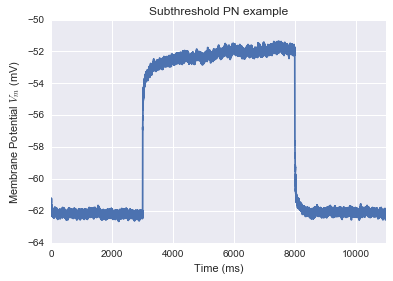

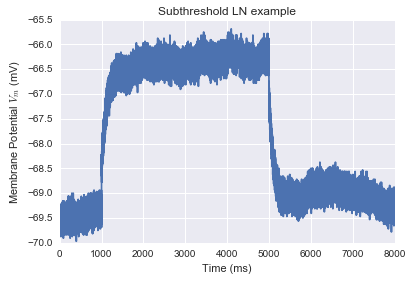

In [97]:
Tpn = 220000*dt
Tln = 160000*dt
tpn = np.arange(0,Tpn,dt)
tln = np.arange(0,Tln,dt)
figure()
plot(tpn*1e3,PN_data[0][0]*1e3)
xlabel('Time (ms)')
xlim(0,11000)
title('Subthreshold PN example')
ylabel('Membrane Potential $V_m$ (mV)')
show()

figure()
plot(tln*1e3,LN_data[0][1]*1e3)
xlabel('Time (ms)')
ylabel('Membrane Potential $V_m$ (mV)')
title('Subthreshold LN example')
show()


There are clearly some features in the membrane potential over a longer timescale than the time constant, which we expect to be over the order of 10 ms. Therefore to extract the time constant we constant by considering the membrane potential during a much smaller time scale - of the order of 50-60 ms after the beginning of the stimulus. We do this using the ```time_constant``` function.

In [98]:
def time_constant(sub_thresh_sweep,stim_start):
    """
    Function to take a subthreshold sweep of either LNs or PNs and return the time constant using the above definition
    in ms
    
    Inputs:
    -------
    sub_thresh_sweep : an array containing the data for a subthreshold sweep.
    stim_start : float, time in seconds of when the stimulus starts
    
    Outputs:
    --------
    time_constant : float (ms)
    """
    hundred_ms = 100
    idx_hundred_ms = 100/(dt*1e3)
    idx_stim_start= int(stim_start/dt)

    V = sub_thresh_sweep
    
    V_time_constant = np.empty_like(V)  #bit of membrane potential which we want to calculate the time constant from
    V_time_constant[:] = V
    
    V_time_constant = V_time_constant[idx_stim_start:int(idx_stim_start+idx_hundred_ms)]
    
    V_time_constant = V_time_constant-min(V_time_constant)
    
    # now find the membrane potential which corresponds to time constant

    tau_Vm = 0.66 * max(V_time_constant)
    
    # find the corresponding time for this potential
    tau_idx = []
    for voltages in range(len(V_time_constant)):
        if V_time_constant[voltages] >= tau_Vm:
            tau_idx.append(voltages)
    
    return tau_idx[0]*dt*1e3


time_constant(PN_data[0][0],stim_start_PN)


5.45

#### Membrane Resistance $R_m$

The membrane resistance can be calculated in the limit for long times, where the solution to the LIF differential equation reduces to 

$$V_h = V_{eq} + R_mI_h $$

This requires knowledge of the holding current, which we only have access to for the LNs. If we know the holding current, then membrane resistance is simply

$$ R_m = \frac{V_h - V_{eq}}{I_h} = \frac{\Delta V}{I_h} $$

where $I_h$ is the holding current and $V_h$ is the holding potential. This is before the 50pA depolarising steps are applied. When these are applied the equation goes to

$$V_s - V_h = R_m I_s $$

$$R_m = \frac{V_s - V_h}{I_s} $$

where the $s$ subscript stands for subthreshold. Using the latter equation we can calculate $R_m$ and subsequently $C_m$ using the time constant. We calculate the $R_m$ using the ```resistance ``` function.

The cell beneath contains the holding currents for each of the LN datasets, as well as a list of the current steps from the 50pA depolarising steps.

In [99]:
holding_currents = [34,-66,-110,20,-120,-86,-52,-104] #holding (initial) injection current for each dataset

LNcurrents = [[] for x in xrange(number_of_datasetsLN)]

LNdatalength = []

for i in range(number_of_datasetsLN):
    LNdatalength.append(len(LNdata[i]))

for dataset in range(number_of_datasetsLN):
    LNcurrents[dataset].append(np.arange(holding_currents[dataset],holding_currents[dataset]+50*LNdatalength[dataset],50))

LNcurrent_list = [[] for x in xrange(number_of_datasetsLN)]
for dataset in range(number_of_datasetsLN):
    LNcurrent_list[dataset].append(LNcurrents[dataset][0].tolist())

In [100]:
def resistance(sub_thresh_sweep,I_h):
    """
    Function to take a subthreshold LN sweep and return the membrane resistance using the above definition in giga Ohms
    
    Inputs:
    -------
    sub_thresh_sweep : array of sweep (mV)
    I_h : holding current (pA)
    
    Outputs:
    --------
    
    membrane resistance : float, membrane resistance in giga Ohms
    """
    
    V = sub_thresh_sweep
    hundred_ms = 100
    idx_hundred_ms = 100/(dt*1e3)
    
    V_h = equilibrium(V,stim_start_LN)[0]
    
    V_s = np.empty_like(V[idx_stim_start_LN:int(idx_stim_start_LN+idx_hundred_ms)])  #bit of membrane potential which we want to calculate the time constant from
    V_s[:] = V[idx_stim_start_LN:int(idx_stim_start_LN+idx_hundred_ms)]
    
    
    V_S = float(np.mean(V_s))
    R_m = (V_S - V_h)/I_h

    return R_m
    figure()
    plot(V_s)
    show()
    
    
    
    
resistance(LN_data[0][0],holding_currents[0])

2.0560328138663486

#### Membrane Capacitance $C_m$

Membrane capacitance can now be calculated from the time constant using $\tau = R_mCm$. The calculation is contained in the function ``` capacitance```

In [103]:
def capacitance(membrane_resistance,time_constant):
    """
    Function to return the membrane capacitance in nano Farads (nF)
    
    Inputs:
    -------
    membrane_resistance : float, membrane resistance calculated for a particular sweep (gOhms)
    time_constant : float time constant tau for a particular sweep
    
    Outputs:
    membrane capacitance : float, membrane capacitance for a particular sweep (nF)
    """
    
    C_m = time_constant/membrane_resistance
    return C_m

capacitance(resistance(LN_data[0][1],holding_currents[0]),time_constant(LN_data[0][1],stim_start_LN))


6.297231515469349

#### Refractory period $t_{ref}$

The last important parameter to extract from the data is a value for the refractory period during which no spike is observed